In [22]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot  as plt
import seaborn as sns
from collections import Counter
from scipy import stats
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split , GridSearchCV ,StratifiedKFold
from sklearn.preprocessing import  StandardScaler , MinMaxScaler ,RobustScaler, FunctionTransformer ,StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import  LogisticRegression
from sklearn.metrics import (
    f1_score, balanced_accuracy_score, precision_recall_fscore_support, 
    roc_auc_score, confusion_matrix, precision_score, recall_score, 
    accuracy_score, average_precision_score
)
from sklearn.ensemble import RandomForestClassifier ,IsolationForest
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.utils.class_weight import compute_class_weight

import warnings
warnings.filterwarnings("ignore")

In [23]:
df = pd.read_csv(r"data\split\trainval.csv")

In [24]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,70320.0,-1.440536,-0.157661,1.951210,3.375675,1.076378,-1.049474,0.043954,0.063408,-1.379699,...,0.163049,0.035337,0.071452,0.710874,0.425002,0.353786,-0.007267,0.108108,62.38,0
1,36855.0,-0.268054,-0.026194,1.862894,-1.989876,-0.551961,-0.310759,0.277641,-0.160598,1.790869,...,0.201588,1.162627,-0.333368,0.171281,0.136557,-0.488836,0.063452,-0.095439,25.95,0
2,42436.0,-3.873686,2.279104,0.434901,-3.173945,-0.504830,0.029066,0.757593,-1.322265,2.122661,...,-0.771537,-1.354687,0.149311,-0.385015,-0.752701,0.449522,-3.542555,-1.439570,17.00,0
3,163977.0,-0.368752,0.922792,1.353228,2.461567,1.451856,2.942073,-0.074470,0.868245,-1.287337,...,0.445099,1.458492,-0.033405,-1.841053,-0.690577,0.123031,0.028285,0.027508,0.00,0
4,130811.0,2.258621,-1.431942,-0.567731,-1.431582,-1.627116,-0.924648,-1.228725,-0.224030,-1.030023,...,-0.137722,0.117330,0.253277,0.026271,-0.289235,-0.179701,0.024791,-0.042692,25.00,0


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56960 entries, 0 to 56959
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    56960 non-null  float64
 1   V1      56960 non-null  float64
 2   V2      56960 non-null  float64
 3   V3      56960 non-null  float64
 4   V4      56960 non-null  float64
 5   V5      56960 non-null  float64
 6   V6      56960 non-null  float64
 7   V7      56960 non-null  float64
 8   V8      56960 non-null  float64
 9   V9      56960 non-null  float64
 10  V10     56960 non-null  float64
 11  V11     56960 non-null  float64
 12  V12     56960 non-null  float64
 13  V13     56960 non-null  float64
 14  V14     56960 non-null  float64
 15  V15     56960 non-null  float64
 16  V16     56960 non-null  float64
 17  V17     56960 non-null  float64
 18  V18     56960 non-null  float64
 19  V19     56960 non-null  float64
 20  V20     56960 non-null  float64
 21  V21     56960 non-null  float64
 22

In [26]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [27]:
df.isna().sum().sum()

np.int64(0)

In [28]:
df.duplicated().sum()

np.int64(62)

In [29]:
df.drop_duplicates(inplace=True)

In [30]:
df.Class.value_counts()

Class
0    56809
1       89
Name: count, dtype: int64

<Axes: xlabel='Class', ylabel='count'>

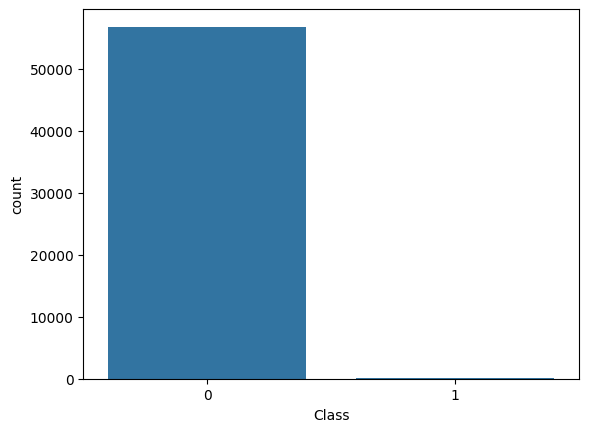

In [31]:
sns.countplot(x= 'Class' ,data=df)

In [32]:

class AdvancedFeatureExtractor:
    """
    Advanced feature extraction with focus on target impact
    """
    
    def __init__(self, target_column='Class'):
        self.target_column = target_column
        self.scalers = {}
        self.models = {}
        
    def anomaly_detection_features(self, df):
        """Create anomaly detection features - highly predictive for fraud detection"""
        print("Creating anomaly detection features...")
        
        numerical_cols = [col for col in df.columns if col != self.target_column and df[col].dtype in ['float64', 'int64']]
        anomaly_features = pd.DataFrame(index=df.index)
        
        try:
            # Isolation Forest anomaly scores
            iso_forest = IsolationForest(contamination=0.1, random_state=42, n_jobs=-1)
            anomaly_scores = iso_forest.fit_predict(df[numerical_cols])
            anomaly_features['isolation_forest_score'] = iso_forest.decision_function(df[numerical_cols])
            anomaly_features['is_anomaly'] = (anomaly_scores == -1).astype(int)
            
            # Statistical outlier detection
            for col in numerical_cols[:15]:  # Top 15 features
                # Z-score based outliers
                z_scores = np.abs(stats.zscore(df[col].fillna(df[col].mean())))
                anomaly_features[f'{col}_zscore_outlier'] = (z_scores > 3).astype(int)
                anomaly_features[f'{col}_zscore_strength'] = z_scores
                
                # IQR based outliers
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                anomaly_features[f'{col}_iqr_outlier'] = ((df[col] < lower_bound) | (df[col] > upper_bound)).astype(int)
                
        except Exception as e:
            print(f"Warning in anomaly detection: {e}")
        
        return anomaly_features
    
    def clustering_features(self, df, n_clusters=8):
        """Create clustering-based features"""
        print("Creating clustering features...")
        
        numerical_cols = [col for col in df.columns if col != self.target_column and df[col].dtype in ['float64', 'int64']]
        cluster_features = pd.DataFrame(index=df.index)
        
        try:
            # Standardize data for clustering
            scaler = StandardScaler()
            scaled_data = scaler.fit_transform(df[numerical_cols])
            
            # K-means clustering
            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(scaled_data)
            
            cluster_features['cluster_id'] = cluster_labels
            
            # Distance to cluster centers
            centers = kmeans.cluster_centers_
            distances = cdist(scaled_data, centers)
            
            for i in range(n_clusters):
                cluster_features[f'dist_to_cluster_{i}'] = distances[:, i]
            
            # Distance to closest cluster center
            cluster_features['min_cluster_distance'] = np.min(distances, axis=1)
            
            # Cluster size (how many points in same cluster)
            cluster_sizes = pd.Series(cluster_labels).value_counts().to_dict()
            cluster_features['cluster_size'] = pd.Series(cluster_labels).map(cluster_sizes)
            
        except Exception as e:
            print(f"Warning in clustering: {e}")
        
        return cluster_features
    
    def nearest_neighbor_features(self, df, n_neighbors=10):
        """Create nearest neighbor based features"""
        print("Creating nearest neighbor features...")
        
        numerical_cols = [col for col in df.columns if col != self.target_column and df[col].dtype in ['float64', 'int64']]
        nn_features = pd.DataFrame(index=df.index)
        
        try:
            # Use most important features for NN
            if self.target_column in df.columns:
                correlations = df[numerical_cols].corrwith(df[self.target_column]).abs().sort_values(ascending=False)
                top_features = correlations.head(10).index.tolist()
            else:
                top_features = numerical_cols[:10]
            
            # Standardize data
            scaler = StandardScaler()
            scaled_data = scaler.fit_transform(df[top_features])
            
            # Nearest neighbors
            nn_model = NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean')
            nn_model.fit(scaled_data)
            
            distances, indices = nn_model.kneighbors(scaled_data)
            
            # Features based on nearest neighbors
            nn_features['avg_nn_distance'] = np.mean(distances[:, 1:], axis=1)  # Exclude self
            nn_features['min_nn_distance'] = np.min(distances[:, 1:], axis=1)
            nn_features['max_nn_distance'] = np.max(distances[:, 1:], axis=1)
            nn_features['std_nn_distance'] = np.std(distances[:, 1:], axis=1)
            
            # Local density estimation
            nn_features['local_density'] = 1 / (nn_features['avg_nn_distance'] + 1e-8)
            
        except Exception as e:
            print(f"Warning in nearest neighbors: {e}")
        
        return nn_features
    
    def target_encoding_features(self, df):
        """Create target encoding features (if target is available)"""
        print("Creating target encoding features...")
        
        if self.target_column not in df.columns:
            return pd.DataFrame(index=df.index)
        
        numerical_cols = [col for col in df.columns if col != self.target_column and df[col].dtype in ['float64', 'int64']]
        target_features = pd.DataFrame(index=df.index)
        
        try:
            # Binned target encoding
            for col in numerical_cols[:15]:
                # Create bins for continuous variables
                try:
                    n_bins = min(10, df[col].nunique())
                    if n_bins > 1:
                        df[f'{col}_binned'] = pd.qcut(df[col], q=n_bins, duplicates='drop', labels=False)
                        
                        # Target mean for each bin
                        bin_means = df.groupby(f'{col}_binned')[self.target_column].mean()
                        target_features[f'{col}_target_mean'] = df[f'{col}_binned'].map(bin_means).fillna(df[self.target_column].mean())
                        
                        # Target std for each bin
                        bin_stds = df.groupby(f'{col}_binned')[self.target_column].std()
                        target_features[f'{col}_target_std'] = df[f'{col}_binned'].map(bin_stds).fillna(df[self.target_column].std())
                        
                        # Count in each bin
                        bin_counts = df.groupby(f'{col}_binned').size()
                        target_features[f'{col}_bin_count'] = df[f'{col}_binned'].map(bin_counts).fillna(1)
                        
                except Exception as e:
                    continue
                    
        except Exception as e:
            print(f"Warning in target encoding: {e}")
        
        return target_features
    
    def advanced_statistical_features(self, df):
        """Create advanced statistical features"""
        print("Creating advanced statistical features...")
        
        numerical_cols = [col for col in df.columns if col != self.target_column and df[col].dtype in ['float64', 'int64']]
        advanced_features = pd.DataFrame(index=df.index)
        
        # Row-wise advanced statistics
        data_matrix = df[numerical_cols].values
        
        # Entropy-like measures
        advanced_features['row_entropy'] = -np.sum(data_matrix * np.log(np.abs(data_matrix) + 1e-8), axis=1)
        
        # Coefficient of variation
        row_means = np.mean(data_matrix, axis=1)
        row_stds = np.std(data_matrix, axis=1)
        advanced_features['row_cv'] = row_stds / (row_means + 1e-8)
        
        # Percentile ranges
        advanced_features['row_p90_p10'] = np.percentile(data_matrix, 90, axis=1) - np.percentile(data_matrix, 10, axis=1)
        advanced_features['row_p95_p5'] = np.percentile(data_matrix, 95, axis=1) - np.percentile(data_matrix, 5, axis=1)
        
        # Number of peaks (local maxima)
        for i in range(len(df)):
            row_data = data_matrix[i, :]
            peaks = 0
            for j in range(1, len(row_data)-1):
                if row_data[j] > row_data[j-1] and row_data[j] > row_data[j+1]:
                    peaks += 1
            advanced_features.loc[df.index[i], 'row_peaks'] = peaks
        
        # Monotonicity measures
        advanced_features['row_monotonic_increase'] = 0
        advanced_features['row_monotonic_decrease'] = 0
        
        for i in range(len(df)):
            row_data = data_matrix[i, :]
            diffs = np.diff(row_data)
            advanced_features.loc[df.index[i], 'row_monotonic_increase'] = (diffs >= 0).sum()
            advanced_features.loc[df.index[i], 'row_monotonic_decrease'] = (diffs <= 0).sum()
        
        return advanced_features
    
    def time_based_features(self, df):
        """Create time-based features if Time column exists"""
        print("Creating time-based features...")
        
        time_features = pd.DataFrame(index=df.index)
        
        if 'Time' not in df.columns:
            return time_features
        
        try:
            # Time since start
            time_features['time_since_start'] = df['Time'] - df['Time'].min()
            
            # Time until end
            time_features['time_until_end'] = df['Time'].max() - df['Time']
            
            # Time periods (assuming seconds)
            time_features['time_hour'] = (df['Time'] / 3600) % 24
            time_features['time_day'] = (df['Time'] / (3600 * 24)) % 7
            
            # Time-based binning
            time_bins = pd.qcut(df['Time'], q=10, labels=False, duplicates='drop')
            time_features['time_bin'] = time_bins
            
            # Rolling statistics if we have target
            if self.target_column in df.columns:
                df_sorted = df.sort_values('Time')
                
                # Rolling mean of target (fraud rate in time windows)
                for window in [100, 500, 1000]:
                    rolling_target = df_sorted[self.target_column].rolling(window=window, min_periods=1).mean()
                    # Map back to original order
                    time_features['rolling_fraud_rate_' + str(window)] = rolling_target.reindex(df.index).fillna(0)
            
        except Exception as e:
            print(f"Warning in time features: {e}")
        
        return time_features
    
    def amount_based_features(self, df):
        """Create amount-based features if Amount column exists"""
        print("Creating amount-based features...")
        
        amount_features = pd.DataFrame(index=df.index)
        
        if 'Amount' not in df.columns:
            return amount_features
        
        try:
            # Amount percentiles
            amount_features['amount_percentile'] = df['Amount'].rank(pct=True)
            
            # Amount z-score
            amount_features['amount_zscore'] = (df['Amount'] - df['Amount'].mean()) / (df['Amount'].std() + 1e-8)
            
            # Amount categories
            amount_features['is_zero_amount'] = (df['Amount'] == 0).astype(int)
            amount_features['is_small_amount'] = (df['Amount'] < df['Amount'].quantile(0.1)).astype(int)
            amount_features['is_large_amount'] = (df['Amount'] > df['Amount'].quantile(0.9)).astype(int)
            
            # Amount bins
            amount_bins = pd.qcut(df['Amount'], q=10, labels=False, duplicates='drop')
            amount_features['amount_bin'] = amount_bins
            
            # Amount vs other features ratios
            numerical_cols = [col for col in df.columns if col != self.target_column and col != 'Amount' and df[col].dtype in ['float64', 'int64']]
            
            if self.target_column in df.columns:
                correlations = df[numerical_cols].corrwith(df[self.target_column]).abs().sort_values(ascending=False)
                top_features = correlations.head(5).index.tolist()
                
                for col in top_features:
                    amount_features[f'amount_to_{col}_ratio'] = df['Amount'] / (np.abs(df[col]) + 1e-8)
                    amount_features[f'amount_minus_{col}'] = df['Amount'] - df[col]
            
        except Exception as e:
            print(f"Warning in amount features: {e}")
        
        return amount_features
    
    def interaction_network_features(self, df):
        """Create complex interaction features"""
        print("Creating network interaction features...")
        
        numerical_cols = [col for col in df.columns if col != self.target_column and df[col].dtype in ['float64', 'int64']]
        network_features = pd.DataFrame(index=df.index)
        
        try:
            if self.target_column in df.columns:
                # Get top correlated features
                correlations = df[numerical_cols].corrwith(df[self.target_column]).abs().sort_values(ascending=False)
                top_features = correlations.head(8).index.tolist()
                
                # Create interaction network
                interaction_count = 0
                for i, col1 in enumerate(top_features):
                    for j, col2 in enumerate(top_features[i+1:], i+1):
                        for k, col3 in enumerate(top_features[j+1:], j+1):
                            if interaction_count >= 10:  # Limit to avoid too many features
                                break
                            
                            # Three-way interactions
                            network_features[f'{col1}_{col2}_{col3}_product'] = df[col1] * df[col2] * df[col3]
                            network_features[f'{col1}_{col2}_{col3}_sum'] = df[col1] + df[col2] + df[col3]
                            
                            interaction_count += 1
                            
                        if interaction_count >= 10:
                            break
                    if interaction_count >= 10:
                        break
                
                # Conditional features
                for col in top_features[:5]:
                    # Features conditional on being above/below median
                    median_val = df[col].median()
                    above_median = df[col] > median_val
                    
                    network_features[f'{col}_above_median'] = above_median.astype(int)
                    network_features[f'{col}_conditional_mean'] = np.where(above_median, df[col], 0)
                    
        except Exception as e:
            print(f"Warning in network features: {e}")
        
        return network_features
    
    def extract_advanced_features(self, df, include_original=True):
        """Extract all advanced features"""
        print("Starting advanced feature extraction...")
        print(f"Original dataset shape: {df.shape}")
        
        # Start with original features
        if include_original:
            feature_df = df.drop(columns=[self.target_column] if self.target_column in df.columns else []).copy()
        else:
            feature_df = pd.DataFrame(index=df.index)
        
        # Add advanced features
        feature_extractors = [
            ('anomaly', self.anomaly_detection_features),
            ('clustering', self.clustering_features),
            ('nearest_neighbors', self.nearest_neighbor_features),
            ('target_encoding', self.target_encoding_features),
            ('advanced_stats', self.advanced_statistical_features),
            ('time_based', self.time_based_features),
            ('amount_based', self.amount_based_features),
            ('network', self.interaction_network_features)
        ]
        
        for name, extractor in feature_extractors:
            try:
                new_features = extractor(df)
                if not new_features.empty:
                    feature_df = pd.concat([feature_df, new_features], axis=1)
                    print(f"After {name} features: {feature_df.shape}")
            except Exception as e:
                print(f"Error in {name} features: {e}")
        
        # Clean data
        print("Cleaning advanced features...")
        feature_df = feature_df.replace([np.inf, -np.inf], np.nan)
        feature_df = feature_df.fillna(0)
        
        # Ensure all numeric
        for col in feature_df.columns:
            if not pd.api.types.is_numeric_dtype(feature_df[col]):
                feature_df[col] = pd.to_numeric(feature_df[col], errors='coerce').fillna(0)
        
        print(f"Final advanced feature set shape: {feature_df.shape}")
        return feature_df
    
    def select_high_impact_features(self, X, y, method='random_forest', k=100):
        """Select features with highest target impact"""
        print(f"Selecting top {k} high-impact features using {method}...")
        
        if method == 'random_forest':
            rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, max_depth=10)
            rf.fit(X, y)
            
            importance_df = pd.DataFrame({
                'feature': X.columns,
                'importance': rf.feature_importances_
            }).sort_values('importance', ascending=False)
            
            print(f"\nTop 15 most impactful features:")
            for i, row in importance_df.head(15).iterrows():
                print(f"{row.name+1:2d}. {row['feature']:<30} (importance: {row['importance']:.6f})")
            
            selected_features = importance_df.head(k)['feature'].tolist()
            return X[selected_features], selected_features
        
        elif method == 'mutual_info':
            selector = SelectKBest(score_func=mutual_info_classif, k=k)
            X_selected = selector.fit_transform(X, y)
            selected_features = X.columns[selector.get_support()].tolist()
            return pd.DataFrame(X_selected, columns=selected_features, index=X.index), selected_features

def create_high_impact_features(df, target_column='Class', n_features=100):
    """
    Main function to create high-impact features
    """
    extractor = AdvancedFeatureExtractor(target_column=target_column)
    
    # Extract advanced features
    advanced_features = extractor.extract_advanced_features(df, include_original=True)
    
    # Select most impactful features if target exists
    if target_column in df.columns:
        X = advanced_features
        y = df[target_column]
        
        selected_features, feature_names = extractor.select_high_impact_features(
            X, y, method='random_forest', k=n_features
        )
        
        return advanced_features, selected_features, feature_names
    
    return advanced_features, None, advanced_features.columns.tolist()

# Usage:
print("=== Creating High-Impact Features ===")
try:
    all_features, selected_features, feature_names = create_high_impact_features(
        df, target_column='Class', n_features=100
    )
    print(f"\n✅ Successfully created {all_features.shape[1]} total features")
    print(f"✅ Selected {selected_features.shape[1] if selected_features is not None else 0} high-impact features")
    
    if selected_features is not None:
        # Show feature importance distribution
        from collections import Counter
        feature_types = Counter([name.split('_')[0] for name in feature_names])
        print(f"\nFeature type distribution in top {len(feature_names)} features:")
        for ftype, count in feature_types.most_common():
            print(f"  {ftype}: {count} features")
    
except Exception as e:
    print(f"❌ Error: {e}")

=== Creating High-Impact Features ===
Starting advanced feature extraction...
Original dataset shape: (56898, 31)
Creating anomaly detection features...
After anomaly features: (56898, 77)
Creating clustering features...
After clustering features: (56898, 88)
Creating nearest neighbor features...
After nearest_neighbors features: (56898, 93)
Creating target encoding features...
After target_encoding features: (56898, 138)
Creating advanced statistical features...
After advanced_stats features: (56898, 145)
Creating time-based features...
After time_based features: (56898, 153)
Creating amount-based features...
After amount_based features: (56898, 169)
Creating network interaction features...
After network features: (56898, 199)
Cleaning advanced features...
Final advanced feature set shape: (56898, 199)
Selecting top 100 high-impact features using random_forest...

Top 15 most impactful features:
173. V17_V14_V10_sum                (importance: 0.064216)
183. V17_V12_V10_sum           

In [33]:
X=selected_features
y= df['Class']

In [34]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full
)

In [35]:
def clip_outliers(X):
    Q1 = np.percentile(X, 25, axis=0)
    Q3 = np.percentile(X, 75, axis=0)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return np.clip(X, lower_bound, upper_bound)


In [36]:
def find_optimal_threshold(model, X_val, y_val, metric='f1'):
    """Find optimal threshold for binary classification using validation set"""
    if not hasattr(model, "predict_proba") or y_val.nunique() != 2:
        return 0.5  # Default threshold for non-probabilistic models or multiclass
    
    probs = model.predict_proba(X_val)[:, 1]
    thresholds = np.arange(0.1, 0.9, 0.01)
    best_score = 0
    best_threshold = 0.5
    
    for threshold in thresholds:
        y_pred = (probs >= threshold).astype(int)
        if metric == 'f1':
            score = f1_score(y_val, y_pred, average='macro')
        elif metric == 'balanced_accuracy':
            score = balanced_accuracy_score(y_val, y_pred)
        
        if score > best_score:
            best_score = score
            best_threshold = threshold
    
    return best_threshold



In [37]:

def comprehensive_evaluation(model, X, y, threshold=0.5, set_name="", model_name=""):
    """Comprehensive evaluation for binary imbalanced datasets"""
    
    # Get probabilities and predictions
    probs = model.predict_proba(X)[:, 1]  # Probability of positive class
    y_pred = (probs >= threshold).astype(int)
    
    # Calculate all binary classification metrics
    accuracy = accuracy_score(y, y_pred)
    balanced_acc = balanced_accuracy_score(y, y_pred)
    
    # F1 scores
    f1_macro = f1_score(y, y_pred, average='macro')
    f1_weighted = f1_score(y, y_pred, average='weighted')
    f1_binary = f1_score(y, y_pred)  # Binary F1 (focuses on positive class)
    
    # Precision and Recall
    precision_macro = precision_score(y, y_pred, average='macro')
    recall_macro = recall_score(y, y_pred, average='macro')
    precision_binary = precision_score(y, y_pred)  # For positive class
    recall_binary = recall_score(y, y_pred)  # For positive class (sensitivity)
    
    # AUC scores
    auc_roc = roc_auc_score(y, probs)
    auc_pr = average_precision_score(y, probs)  # Area under Precision-Recall curve
    
    # Per-class metrics
    precision_per_class, recall_per_class, f1_per_class, support = precision_recall_fscore_support(
        y, y_pred, average=None, zero_division=0
    )
    
    # Confusion matrix elements
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    
    # Additional binary metrics
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Same as recall
    
    # Positive and Negative Predictive Values
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Same as precision
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value
    
    return {
        # Basic metrics
        'accuracy': accuracy,
        'balanced_accuracy': balanced_acc,
        
        # F1 scores
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'f1_binary': f1_binary,
        
        # Precision and Recall
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'precision_binary': precision_binary,
        'recall_binary': recall_binary,
        
        # AUC scores
        'auc_roc': auc_roc,
        'auc_pr': auc_pr,
        
        # Binary-specific metrics
        'sensitivity': sensitivity,  # Same as recall
        'specificity': specificity,
        'ppv': ppv,  # Positive Predictive Value (same as precision)
        'npv': npv,  # Negative Predictive Value
        
        # Confusion matrix elements
        'true_positives': tp,
        'true_negatives': tn,
        'false_positives': fp,
        'false_negatives': fn,
        
        # Per-class arrays (for compatibility)
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class,
        'f1_per_class': f1_per_class,
        'support': support,
        
        # Raw outputs
        'probabilities': probs,
        'predictions': y_pred,
        'threshold': threshold
    }

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Simplified models configuration for imbalanced datasets
models = {
    'LogisticRegression': (
        LogisticRegression(
            max_iter=1000,
            class_weight='balanced',
            random_state=42
        ),
        {
            'C': [0.1, 1.0, 10.0]
        },
        True
    ),
    
    'Random Forest': (
        RandomForestClassifier(
            random_state=42,
            class_weight='balanced',
            n_jobs=-1
        ),
        {
            "n_estimators": [100, 200],
            "max_depth": [10, 20]
        },
        True
    ),
    
    'XGBoost': (
        XGBClassifier(
            random_state=42,
            use_label_encoder=False,
            eval_metric='logloss',
            objective='binary:logistic',
            n_jobs=-1
        ),
        {
            "n_estimators": [100, 200],
            "max_depth": [3, 6],
            "learning_rate": [0.1, 0.2],
            "scale_pos_weight": [1, 5]
        },
        True
    ),
    
    'LightGBM': (
        LGBMClassifier(
            random_state=42,
            verbose=-1,
            objective='binary',
            is_unbalance=True,
            n_jobs=-1
        ),
        {
            "n_estimators": [100, 200],
            "learning_rate": [0.1, 0.2]
        },
        True
    ),
    
    'CatBoost': (
        CatBoostClassifier(
            random_state=42,
            verbose=False,
            auto_class_weights='Balanced'
        ),
        {
            "iterations": [100, 200],
            "learning_rate": [0.1, 0.2]
        },
        True
    ),
    
    # Balanced Bagging
    'Balanced_Bagging': (
        BaggingClassifier(
            estimator=DecisionTreeClassifier(class_weight='balanced', random_state=42),
            n_estimators=50,
            random_state=42,
            n_jobs=-1
        ),
        {
            "n_estimators": [50, 100]
        },
        True
    ),
    
    # Voting Classifier
    'Voting': (
        VotingClassifier(
            estimators=[
                ('lr', LogisticRegression(class_weight='balanced', random_state=42)),
                ('rf', RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=42)),
                ('xgb', XGBClassifier(n_estimators=50, objective='binary:logistic', random_state=42, eval_metric='logloss'))
            ],
            voting='soft',
            n_jobs=-1
        ),
        {},
        False
    ),
    
    # Stacking Classifier
    'Stacking': (
        StackingClassifier(
            estimators=[
                ('rf', RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=42)),
                ('xgb', XGBClassifier(n_estimators=50, objective='binary:logistic', random_state=42, eval_metric='logloss')),
                ('lgbm', LGBMClassifier(n_estimators=50, objective='binary', is_unbalance=True, random_state=42, verbose=-1))
            ],
            final_estimator=LogisticRegression(class_weight='balanced', random_state=42),
            cv=3,
            n_jobs=-1
        ),
        {
            "cv": [3, 5]
        },
        True
    )
}

In [39]:
# Main training and evaluation code
import warnings
warnings.filterwarnings('ignore')

best_models = {}
results = []
detailed_results = []

# Use stratified CV for better handling of imbalanced data
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, (model, params, scale) in models.items():
    print(f"\nTraining and tuning {name}...")
    
    try:
        if scale:
            # Apply scaling
            scaler = RobustScaler()
            X_train_used = scaler.fit_transform(clip_outliers(X_train))
            X_val_used = scaler.transform(clip_outliers(X_val))
            X_test_used = scaler.transform(clip_outliers(X_test))
        else:
            X_train_used, X_val_used, X_test_used = X_train, X_val, X_test
        
        # Handle models with and without hyperparameter tuning
        if params:  # If there are parameters to tune
            # Use stratified cross-validation and appropriate scoring for imbalanced data
            grid = GridSearchCV(
                model, 
                params, 
                cv=stratified_cv, 
                n_jobs=-1, 
                scoring='f1',  # F1 for binary classification
                verbose=0,  # Reduced verbosity
                error_score='raise'
            )
            
            grid.fit(X_train_used, y_train)
            best_model = grid.best_estimator_
            
            print(f"Best params: {grid.best_params_}")
            print(f"Best CV score: {grid.best_score_:.4f}")
            
        else:  # No hyperparameter tuning (e.g., for voting classifiers)
            best_model = model
            best_model.fit(X_train_used, y_train)
            
            # Calculate CV score manually for comparison
            cv_scores = cross_val_score(best_model, X_train_used, y_train, 
                                       cv=stratified_cv, scoring='f1', n_jobs=-1)
            print(f"CV F1 score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        
        best_models[name] = best_model
        
        # Find optimal threshold using validation set for binary classification
        try:
            optimal_threshold = find_optimal_threshold(best_model, X_val_used, y_val, metric='f1')
            print(f"Optimal threshold: {optimal_threshold:.4f}")
        except Exception as e:
            print(f"Warning: Could not find optimal threshold for {name}: {e}")
            optimal_threshold = 0.5  # Default threshold
        
        # Evaluate on all sets
        sets = {
            "Train": (X_train_used, y_train),
            "Validation": (X_val_used, y_val),
            "Test": (X_test_used, y_test)
        }
        
        for set_name, (X_set, y_set) in sets.items():
            try:
                eval_results = comprehensive_evaluation(
                    best_model, X_set, y_set, optimal_threshold, set_name, name
                )
                
                # Store basic results with binary metrics
                results.append({
                    "Model": name,
                    "Set": set_name,
                    "F1_Macro": round(eval_results.get('f1_macro', 0), 4),
                    "F1_Binary": round(eval_results.get('f1_binary', 0), 4),
                    "F1_Weighted": round(eval_results.get('f1_weighted', 0), 4),
                    "Balanced_Accuracy": round(eval_results.get('balanced_accuracy', 0), 4),
                    "AUC_ROC": round(eval_results.get('auc_roc', 0), 4),
                    "AUC_PR": round(eval_results.get('auc_pr', 0), 4),
                    "Precision": round(eval_results.get('precision_binary', 0), 4),
                    "Recall": round(eval_results.get('recall_binary', 0), 4),
                    "Specificity": round(eval_results.get('specificity', 0), 4)
                })
                
                # Store detailed results
                detailed_results.append({
                    'model': name,
                    'set': set_name,
                    'threshold': optimal_threshold,
                    **eval_results
                })
                
                # Print detailed report for validation set only
                if set_name == "Validation":
                    y_pred = eval_results['predictions']
                    
                    print(f"\n=== {name} - {set_name} Set Results ===")
                    print(f"🎯 Threshold: {optimal_threshold:.4f}")
                    
                    # Key binary metrics
                    print(f"\n📈 Key Metrics:")
                    print(f"   F1-Binary (Positive Class): {eval_results.get('f1_binary', 0):.4f}")
                    print(f"   F1-Macro: {eval_results.get('f1_macro', 0):.4f}")
                    print(f"   Balanced Accuracy: {eval_results.get('balanced_accuracy', 0):.4f}")
                    
                    # Precision/Recall for positive class
                    print(f"\n🔍 Positive Class Performance:")
                    print(f"   Precision: {eval_results.get('precision_binary', 0):.4f}")
                    print(f"   Recall (Sensitivity): {eval_results.get('recall_binary', 0):.4f}")
                    print(f"   Specificity: {eval_results.get('specificity', 0):.4f}")
                    
                    # AUC scores
                    print(f"\n📊 AUC Scores:")
                    print(f"   AUC-ROC: {eval_results.get('auc_roc', 0):.4f}")
                    print(f"   AUC-PR: {eval_results.get('auc_pr', 0):.4f}")
                    
                    # Confusion Matrix with labels
                    print(f"\n🔢 Confusion Matrix:")
                    print(f"   True Negatives:  {eval_results.get('true_negatives', 0):,}")
                    print(f"   False Positives: {eval_results.get('false_positives', 0):,}")
                    print(f"   False Negatives: {eval_results.get('false_negatives', 0):,}")
                    print(f"   True Positives:  {eval_results.get('true_positives', 0):,}")
                    
                    # Classification report
                    try:
                        present_classes = np.unique(np.concatenate([y_set, y_pred]))
                        present_class_names = ['Negative', 'Positive']
                        print(f"\nClassification Report:")
                        print(classification_report(
                            y_set, y_pred,
                            labels=present_classes,
                            target_names=present_class_names,
                            zero_division=0
                        ))
                    except Exception as e:
                        print(f"Could not generate classification report: {e}")
                        
            except Exception as e:
                print(f"Error evaluating {name} on {set_name} set: {e}")
                continue
                
    except Exception as e:
        print(f"Error training {name}: {e}")
        continue

# Create summary DataFrames
results_df = pd.DataFrame(results)

if not results_df.empty:
    print("\n" + "="*80)
    print("SUMMARY OF BINARY CLASSIFICATION RESULTS")
    print("="*80)

    # F1 scores summary
    print("\nF1 Scores Summary:")
    try:
        f1_summary = results_df.pivot_table(
            index='Model', 
            columns='Set', 
            values=['F1_Binary', 'F1_Macro'], 
            aggfunc='first'
        )
        print(f1_summary)
    except Exception as e:
        print(f"Could not create F1 summary: {e}")

    # Key binary metrics summary
    print("\nKey Binary Metrics Summary:")
    try:
        binary_metrics = results_df.pivot_table(
            index='Model',
            columns='Set', 
            values=['Precision', 'Recall', 'Specificity'],
            aggfunc='first'
        )
        print(binary_metrics)
    except Exception as e:
        print(f"Could not create binary metrics summary: {e}")

    # AUC scores summary
    print("\nAUC Scores Summary:")
    try:
        auc_summary = results_df.pivot_table(
            index='Model',
            columns='Set',
            values=['AUC_ROC', 'AUC_PR'],
            aggfunc='first'
        )
        print(auc_summary)
    except Exception as e:
        print(f"Could not create AUC summary: {e}")

    # Balanced Accuracy summary  
    print("\nBalanced Accuracy Summary:")
    try:
        balanced_acc_pivot = results_df.pivot(index='Model', columns='Set', values='Balanced_Accuracy')
        print(balanced_acc_pivot)
    except Exception as e:
        print(f"Could not create balanced accuracy summary: {e}")

    # Find best model based on validation metrics
    try:
        val_results = results_df[results_df['Set'] == 'Validation'].copy()
        if not val_results.empty:
            best_model_f1_binary = val_results.loc[val_results['F1_Binary'].idxmax(), 'Model']
            best_model_auc_pr = val_results.loc[val_results['AUC_PR'].idxmax(), 'Model']

            print(f"\n🏆 Model Selection:")
            print(f"   Best Model (F1-Binary): {best_model_f1_binary}")
            print(f"   Best Model (AUC-PR): {best_model_auc_pr}")
    except Exception as e:
        print(f"Could not determine best models: {e}")

    # Class imbalance analysis
    print(f"\n📊 Class Distribution Analysis:")
    try:
        print(f"Training set class distribution:")
        train_dist = pd.Series(y_train).value_counts().sort_index()
        print(f"   Negative (0): {train_dist[0]:,} ({train_dist[0]/len(y_train)*100:.2f}%)")
        print(f"   Positive (1): {train_dist[1]:,} ({train_dist[1]/len(y_train)*100:.2f}%)")
        print(f"   Imbalance Ratio: {train_dist[0]/train_dist[1]:.1f}:1")

        # Calculate class weights for reference
        if len(np.unique(y_train)) > 1:
            class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
            print(f"\n⚖️ Computed Class Weights:")
            print(f"   Negative (0): {class_weights[0]:.3f}")
            print(f"   Positive (1): {class_weights[1]:.3f}")
    except Exception as e:
        print(f"Could not perform class distribution analysis: {e}")

    # Performance insights for imbalanced data
    print(f"\n💡 Key Insights:")
    print(f"   • F1-Binary focuses on positive class performance")
    print(f"   • AUC-PR is more informative than AUC-ROC for imbalanced data")
    print(f"   • High specificity shows good negative class recognition")
    print(f"   • Balance precision vs recall based on business needs")
    print(f"   • Ensemble methods often provide more robust predictions")

else:
    print("No results were generated. Please check for errors above.")


Training and tuning LogisticRegression...
Best params: {'C': 10.0}
Best CV score: 0.6567
Optimal threshold: 0.8400

=== LogisticRegression - Validation Set Results ===
🎯 Threshold: 0.8400

📈 Key Metrics:
   F1-Binary (Positive Class): 0.8421
   F1-Macro: 0.9209
   Balanced Accuracy: 0.9443

🔍 Positive Class Performance:
   Precision: 0.8000
   Recall (Sensitivity): 0.8889
   Specificity: 0.9996

📊 AUC Scores:
   AUC-ROC: 0.9622
   AUC-PR: 0.7885

🔢 Confusion Matrix:
   True Negatives:  11,358
   False Positives: 4
   False Negatives: 2
   True Positives:  16

Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00     11362
    Positive       0.80      0.89      0.84        18

    accuracy                           1.00     11380
   macro avg       0.90      0.94      0.92     11380
weighted avg       1.00      1.00      1.00     11380


Training and tuning Random Forest...
Best params: {'max_depth': 10, 'n_estimators'